## Copernicus Seasonal Forecast Module

This module is developed to manage seasonal forecast data from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu) (CDS) for the [U-CLIMADAPT project](https://www.copernicus-user-uptake.eu/user-uptake/details/responding-to-the-impact-of-climate-change-u-climadapt-488). 
It offers comprehensive tools for downloading, processing, computing climate indices, and generating hazard objects based on seasonal forecast datasets, particularly [Seasonal forecast daily and subdaily data on single levels](https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=overview). 
The module is tailored to integrate seamlessly with the [CLIMADA](https://climada.ethz.ch/)(CLIMate ADAptation) platform, supporting climate risk assessment and the development of effective adaptation strategies.

Features:
- Download seasonal forecast data from CDS
- Process raw data into climate indices
- Calculate various heat-related indices (e.g., Maximum Temperature, Tropical Nights)
- Create CLIMADA Hazard objects for further risk analysis
- Visualize hazard data

Prerequisites:

1. CDS account and API key:
   Register at https://cds-beta.climate.copernicus.eu

2. CDS API client installation:
   pip install cdsapi

3. CDS API configuration:
   Create a .cdsapirc file in your home directory with your API key and URL.
   For instructions, visit: https://cds-beta.climate.copernicus.eu/how-to-api#install-the-cds-api-client

4. Dataset Terms and Conditions: After selecting the dataset to download, make 
   sure to accept the terms and conditions on the corresponding dataset webpage in the CDS portal before running this notebook. Here, https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=download.

Usage:
This module is typically imported and used within larger scripts or applications for climate data processing
and risk assessment. See individual function docstrings for specific usage instructions.

Note:
Ensure you have the necessary permissions and comply with the CDS data usage policies when using this module. You can view the terms and conditions at https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=download. You can find them at the bottom of the download page.

In [1]:
# Import packages

import warnings
import datetime as dt
warnings.filterwarnings('ignore')
from pathlib import Path

from climada.hazard import Hazard
from climada_petals.hazard.copernicus_forecast.create_seasonal_forecast_hazard import SeasonalForecast

from climada.util.constants import SYSTEM_DIR

# Initialize handler
handler = SeasonalForecast()


### Set up module parameters

To configure the module for working with Copernicus forecast data and converting it into a hazard object for CLIMADA, you will need to define several essential parameters. These settings are crucial as they specify the type of data to be retrieved, the format, the forecast period, and the geographical area of interest. These parameters influence how the forecast data is processed and transformed into a hazard object.

Below, we outline these parameters and use an example for the "Maximum Temperature" index to demonstrate the seasonal forecast functionality.

To learn more about what these parameters entail and their significance, please refer to the [documentation on the CDS webpage](https://cds-beta.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=overview).

#### Overview of parameters

**index_metric**: Defines the type of index to be calculated. The current options available are 'HIA' (Heat Index Adjusted), 'HIS' (Heat Index Simplified), 'Tmean' (Mean Temperature), 'Tmin' (Minimum Temperature), 'Tmax' (Maximum Temperature), 'HW' (Heat Wave), 'TR' (Tropical Nights), 'TX30' (Hot Days), 'HUM' (Humidex), 'RH' (Relative Humidity), 'AT' (Apparent Temperature), and 'WBGT' (Wet Bulb Globe Temperature (Simple)).

**Heat Wave Parameters (specific to "HW" hazard)**: If index_metric is set to 'HW' for heat wave calculations, additional parameters can be specified to fine-tune the heat wave detection:

- threshold: Temperature threshold above which days are considered part of a heat wave. Default is 27°C.
- min_duration: Minimum number of consecutive days above the threshold required to define a heat wave event. Default is 3 days.
- max_gap: Maximum allowable gap (in days) between two heat wave events to consider them as one single event. Default is 0 days.

**Tropical Nights Parameters (specific to "TR" hazard)**: If index_metric is set to 'TR' for tropical nights, an additional parameter can be specified to set the threshold:

- threshold: Nighttime temperature threshold, above which a night is considered "tropical." Default is 20°C.

**format** : Specifies the format of the data to be downloaded, "grib" or "netcdf". Noted that GRIB files are more complex to process compared to NetCDF.

**originating_centre**: Identifies the source of the data. A standard choice is "dwd" (German Weather Service), one of eight providers including ECMWF, UK Met Office, Météo France, CMCC, NCEP, JMA, and ECCC.

**system**: Refers to a specific model or configuration used for forecasts. In this script, the default value is "21," which corresponds to the GCSF (German Climate Forecast System) [version 2.1](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020MS002101). More details can be found in the [CDS documentation](https://cds-beta.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=documentation).

**max_lead_month**: Defines the maximum lead time in months for forecast data. For this example we set it to 4 months, meaning forecasts up to four months into the future. The maximum available is 7 months.

**year_list**: A list of years for which data should be downloaded and processed.

**month_list**: Starting months for seasonal forecast data. [6, 7] means data starts from June and July.

**area_selection**: This determines the geographical area for which the data should be downloaded. It can be set to
- "global" (gobal data is downloaded)
- a list of ISO alpha-3 codes for different countries, e.g., ["DEU", "CHE"] for Germany and Switzerland. See this [wikipedia page](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) for the country codes. Note that the **joint region** will be downloaded and processed, i.e., handling data for ["DEU", "CHE"] and then for ["CHE"] will download and generate two sets of data.
- a list of four numbers corresponding to the geographical bounds (in degrees; EPSG:4326), specified as [north, west, south, east]. 

**overwrite**: Boolean flag that, when set to True, forces the system to redownload and reprocess existing files.


In [4]:
# We define above parameters for an example 
index_metric = "TR" # maximum temperature
format = "grib"  # 'grib' or 'netcdf'
originating_centre =  "dwd"
system =  "21" 
max_lead_month = 4
year_list = [2024] 
month_list = [6, 7]
area_selection = ["DEU", "CHE"] 
overwrite = False

# Parameters for Heat Waves 
threshold = 27
min_duration = 3
max_gap = 0

# Parameters for Tropical Nights 
threshold_tr = 20

# Details on the characteristics of the selected index and the input data used
handler.explain_index(index_metric)

Explanation for 'TR': Tropical Nights: This indicator counts the number of nights where the minimum temperature remains above a certain threshold, typically 20°C.
Required Input Data: ['2m temperature (t2m)']


### Download and Process Data

The `handler.download_and_process_data` method in CLIMADA efficiently retrieves and organizes Copernicus forecast data. It checks for existing files to avoid redundant downloads, stores data by format (grib or netCDF), year, month. Then the files are processed for further analysis, such as calculating climate indices or creating hazard objects within CLIMADA. Here are the aspects of this process:

- **Data Download**: The method downloads the forecast data for the selected years, months, and regions. The data is retrieved in **grib** or **netCDF** formats, which are commonly used for storing meteorological data. If the required files already exist in the specified directories, the system will skip downloading them, as indicated by the log messages such as:  
  *"Corresponding grib file SYSTEM_DIR/copernicus_forecast/input_data/dwd/grib/2022/06/t2m_area-16_63_47_4_202206.grib already exists."*

- **Data Processing**: After downloading (or confirming the existence of) the files, the system converts them into daily **netCDF** files. This format suseful for working with multi-dimensional climate data. The log messages confirm the existence or creation of these files, for example:  
  *"Daily file SYSTEM_DIR/copernicus_forecast/input_data/netcdf/daily/dwd/2022/06/t2m_area-16_63_47_4_202206.nc already exists."*

- **Geographic and Temporal Focus**: The files are generated for a specific time frame (e.g., June and July 2022) and a predefined geographic region, as specified by the parameters such as `area_selection`, `month_list`, and `year_list`. This ensures that only the selected data for your analysis is downloaded and processed.

- **Data Completeness**: Messages like "already exists" ensure that you do not redundantly download or process data, saving time and computing resources. However, if the data files are missing, they will be downloaded and processed as necessary.

In [5]:
# Download and process data
handler.download_and_process_data(index_metric, year_list, month_list, area_selection, overwrite, format, originating_centre, system, max_lead_month)

2024-11-15 14:26:08,172 | INFO : 489 leadtimes to download.


2024-11-15 14:26:08,173 - climada_petals.hazard.copernicus_forecast.downloader - WARNING - Please ensure you have reviewed and accepted the terms and conditions for the use of this dataset. Access the terms here: https://cds-beta.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=download


2024-11-15 14:26:08,411 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-15 14:26:08,411 | INFO : [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-15 14:26:08,413 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-15 

2024-11-15 14:32:34,494 - climada_petals.hazard.copernicus_forecast.downloader - INFO - File successfully downloaded to /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/input_data/dwd/grib/2024/06/t2m_area4_56_45_16.grib.


2024-11-15 14:32:34,496 | INFO : 493 leadtimes to download.


2024-11-15 14:32:34,498 - climada_petals.hazard.copernicus_forecast.downloader - WARNING - Please ensure you have reviewed and accepted the terms and conditions for the use of this dataset. Access the terms here: https://cds-beta.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=download


2024-11-15 14:32:34,713 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-15 14:32:34,713 | INFO : [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-15 14:32:34,715 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-15 

2024-11-15 14:36:56,996 - climada_petals.hazard.copernicus_forecast.downloader - INFO - File successfully downloaded to /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/input_data/dwd/grib/2024/07/t2m_area4_56_45_16.grib.


### Calculate Climate Indices

When you use the `handler.calculate_index` method in CLIMADA to compute specific climate indices (such as Maximum Temperature), the generated output is saved and organized in a structured format for further analysis. Here some details:

- **Index Calculation**: The method processes seasonal forecast data to compute the selected index for the chosen years, months, and regions. This index represents a specific climate condition, such as the number of Maximum Temperature ("Tmax") over the forecast period, as defined in the parameters.

- **Data Storage**: The calculated index data is saved in **netCDF** format. These files are automatically saved in directories specific to the index and time period. The file paths are printed below the processing steps. For example, the computed index values are stored in:  
  *"SYSTEM_DIR/copernicus_forecast/indices/dwd/Tmax/2022/06/Tmax_area4_56_45_16_202206.nc"*

  Similarly, the statistics of the index (e.g., mean, max, min, std) are saved in:  
  *"SYSTEM_DIR/copernicus_forecast/indices/dwd/Tmax/2022/06/stats/stats_Tmax_area4_56_45_16_202206.nc"*.  
  These files ensure that both the raw indices and their statistical summaries are available for detailed analysis.
  
  Each file contains data for a specific month and geographic region, as defined in the parameters. This allows you to analyze how the selected climate index varies over time and across different locations.

- **Completeness of Data Processing**: Messages 'Index Tmax successfully calculated and saved for...' confirm the successful calculation and storage of the index, ensuring that all requested data has been processed and saved correctly.


In [6]:
# Calculate index
handler.calculate_index(index_metric, year_list, month_list, area_selection, overwrite, originating_centre, threshold_tr)

2024-11-15 14:43:54,083 | INFO : Writing index data to /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/indices/dwd/TR/2024/06/monthly_area4_56_45_16.nc.
2024-11-15 14:43:54,098 | INFO : Index TR successfully calculated and saved for 2024-06.


Data saved at:
- Monthly index: /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/indices/dwd/TR/2024/06/monthly_area4_56_45_16.nc
- Statistics: /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/indices/dwd/TR/2024/06/stats_area4_56_45_16.nc


2024-11-15 14:43:59,115 | INFO : Writing index data to /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/indices/dwd/TR/2024/07/monthly_area4_56_45_16.nc.
2024-11-15 14:43:59,132 | INFO : Index TR successfully calculated and saved for 2024-07.


Data saved at:
- Monthly index: /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/indices/dwd/TR/2024/07/monthly_area4_56_45_16.nc
- Statistics: /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/indices/dwd/TR/2024/07/stats_area4_56_45_16.nc


### Calculate a Hazard Object

When you use the `handler.process_and_save_hazards` method in CLIMADA to convert processed index from Copernicus forecast data into a hazard object:

- **Hazard Object Creation**: The method processes seasonal forecast data for specified years and months, converting these into hazard objects. These objects encapsulate potential risks associated with specific weather events or conditions, such as Maximum Temperature ('Tmax') indicated in the parameters, over the forecast period.

- **Data Storage**: The hazard data for each ensemble member of the forecast is saved as HDF5 files. These files are automatically stored in specific directories corresponding to each month and type of hazard. The file paths are printed below the processing steps. For example, *"/SYSTEM_DIR/copernicus_forecast/hazard/dwd/Tmax/2022/06/hazard_Tmax_area4_56_45_16_202207.hdf5"*
 HDF5 is a versatile data model that efficiently stores large volumes of complex data.
 
 Each file is specific to a particular month and hazard scenario ('Tmax' in this case) and covers all ensemble members for that forecast period, aiding in detailed risk analysis.

- **Completeness of Data Processing**: Messages like 'Completed processing for 2022-07. Data saved in...' confirm the successful processing and storage of the hazard data for that period, ensuring that all requested data has been properly handled and stored.

#### Visualizing the Calculated Hazard Object

Once the hazard object has been successfully calculated, the last element created is printed for visualization. This is important for several reasons:

- **Initial Data Inspection**: The visualization allows you to view a slice of the forecast data, providing a quick check of the results. This initial glimpse helps you verify that the data processing was successful and provides insights into the distribution of the hazard (in this case, Maximum Temperature) across the area of interest.

- **Geographic Accuracy**: The map helps you verify if the correct geographic region was processed and plotted. This is particularly useful as it allows immediate feedback on whether the user-defined boundaries or selected areas (e.g., Germany and Switzerland) were captured correctly.

- **Data Quality Check**: Visualizing the output also serves as a preliminary quality check, allowing you to detect any unexpected results or anomalies in the data. For instance, the color bar indicating the "Intensity (days)" gives an indication of how the hazard index is distributed across the mapped area.

- **Quick Workflow Testing**: This step is essential for testing the entire workflow, ensuring that the process is working as expected from data download, processing, and hazard object creation to visualization.

This output provides a structured dataset ready for further analysis within the CLIMADA framework, allowing for the evaluation of potential impacts and the planning of mitigation strategies. 


2024-11-15 14:44:30,340 - climada.hazard.io - INFO - Writing /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/hazard/dwd/TR/2024/06/hazard_area4_56_45_16.hdf5
2024-11-15 14:44:30,372 - climada.hazard.centroids.centr - INFO - Writing /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/hazard/dwd/TR/2024/06/hazard_area4_56_45_16.hdf5
Completed processing for 2024-06. Data saved in /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/hazard/dwd/TR/2024/06.
2024-11-15 14:44:30,918 - climada.hazard.io - INFO - Writing /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/hazard/dwd/TR/2024/07/hazard_area4_56_45_16.hdf5
2024-11-15 14:44:30,947 - climada.hazard.centroids.centr - INFO - Writing /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/hazard/dwd/TR/2024/07/hazard_area4_56_45_16.hdf5
Completed processing for 2024-07. Data saved in /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/hazard/dwd/TR/2024/07.
2024-11-15 14:44:30,

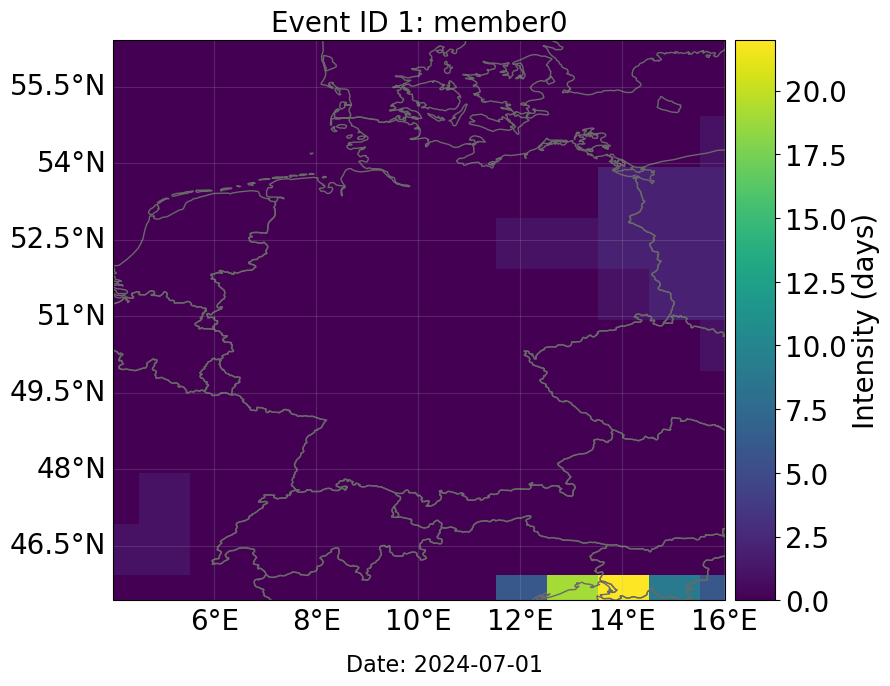

In [8]:
handler.save_index_to_hazard(index_metric, year_list, month_list, area_selection, overwrite, originating_centre)

## Example for reading and plotting hazard

The saved hazard file can then be read and processed by standard CLIMADA methods. For instance, below, we load the hazard for the last month and plot the intensity per grid point maximized over all forecast ensemble members.

2024-11-15 14:44:47,669 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_data/seasonal_forecasts/hazard/dwd/TR/2024/07/hazard_area4_56_45_16.hdf5


<GeoAxes: title={'center': 'TR max intensity at each point'}>

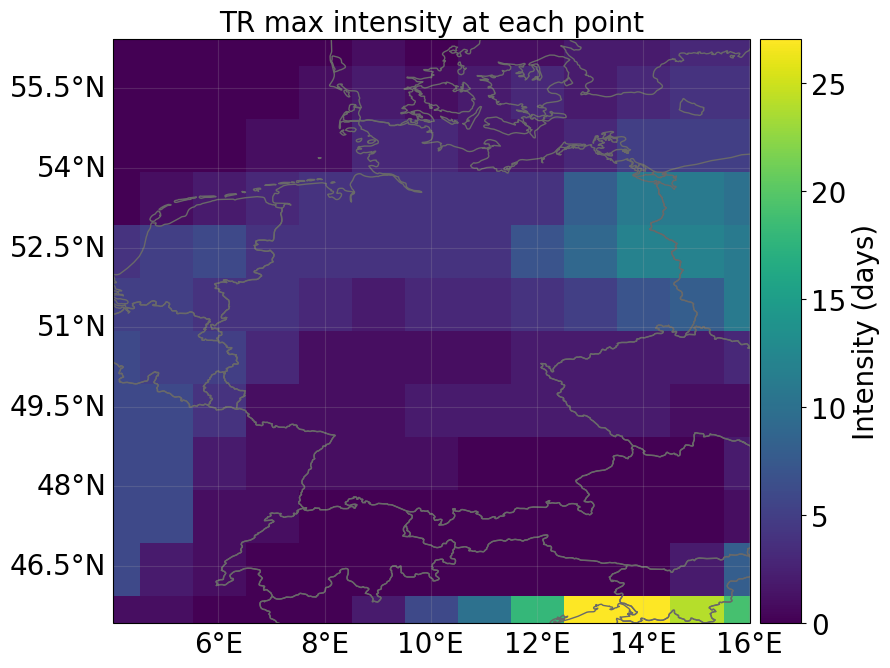

In [9]:
# Choose the example hazard
year = year_list[-1]  # Retrieve the last year in the list for the example
month = month_list[-1]  # Retrieve the last month in the list for the example
ordinal_date = dt.datetime.fromisoformat(f"{year}-{month:02d}-01").toordinal()  # Convert date to ordinal format
bounds = handler._get_bounds_for_area_selection(area_selection)  # Get bounds for the area selection
area_str = f"area{int(bounds[1])}_{int(bounds[0])}_{int(bounds[2])}_{int(bounds[3])}"

# Define the correct hazard directory and path
hazard_directory = f"{handler.data_out}/hazard/{originating_centre}/{index_metric}/{year}/{month:02d}"  
hazard_path = f"{hazard_directory}/hazard_{area_str}.hdf5" 

# Load the hazard and plot intensity for the selected grid, maximized over ensemble
haz = Hazard.from_hdf5(hazard_path)  # Load the hazard object from the defined path
haz.select(date=[ordinal_date, ordinal_date]).plot_intensity(event=0, smooth=False)  # Plot intensity for the selected event
